<h1>Task 3 : Quanvolutional Neural Networks <h1>

#### **Main Objectives :**
This notebook aims to understand the use of quanvolutional neural networks in image processing and compare its cost and accuracy to the classical counterpart. We followed the "Quanvolutional Neural Networks" tutorial from Pennylane authored by Andrea Mari. Our understanding of the tutorial is demonstrated by the comments and explanations provided for each step. For the last part, we took the liberty of running both classical and quantum models with a larger epoch number to see what the difference would be. We suspect accuracy to increase and loss to decrease as epoch number increase.

In [ ]:
"""
https://pennylane.ai/qml/demos/tutorial_quanvolution/
"""
#!pip install tensorflow

# importing pennylane, tensorflow, and other libraries.

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-05 19:18:00.447473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# setting of the main hyper-parameters of the model

n_epochs = 30 # number of optimization epochs or "rounds" the data will go through the model.
n_layers = 1  # number of random layers
n_train = 50 # size of the train dataset
n_test = 30 # size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/" # Data saving folder
PREPROCESS = True# if False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0) # Seed for NumPy random number generator
tf.random.set_seed(0) # Seed for TensorFlow random number generator

import os
os.makedirs(SAVE_PATH, exist_ok = True) # creating a directory for SAVE_PATH.


<h2>Loading the MNIST Dataset<h2>

In [ ]:

mnist_dataset = keras.datasets.mnist # downloading MNIST data from keras.
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data() # splitting data into test and train.

# reduce dataset size
train_images = train_images[:n_train] # from 0th element to n_train-1 element. Limiting data would speed up the evaluation.
train_labels = train_labels[:n_train]

test_images = test_images[:n_test] # from 0th element to n_test-1 element.
test_labels = test_labels[:n_test]

#Normalize pixel values within 0 and 1
train_images = train_images/255
test_images = test_images/255

#add extra dimensions for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


<h2> Quantum Circuit as a convolution kernel<h2>

In [ ]:
dev = qml.device("default.qubit", wires=4) # creating quantum device.

#random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j) # applying RY gates

    # Random quantum circuit
    RandomLayers(rand_params, wires = list(range(4)))

    # measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]



In [ ]:
def quanv(image):

    ## Convolves the input image with many applications of the same quantum circui.

    out = np.zeros((14,14,4)) # create 4 arrays of 14x14 in a list.

    #loop over the coordinates of the top_left pixel of 2x2 squres
    for j in range(0,28,2):
        for k in range(0,28,2):
            #process a squared 2x2 regoin of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j,k,0], # pass the top left hand corner of img data.
                    image[j,k+1,0], # pass the top right hand corner of img data.
                    image[j+1, k,0], # pass the bottom left hand corner of img data.
                    image[j+1, k+1, 0] # pass the bottom right hand corner of img data.
                ]
            )
            #Assign expectation values to different channels of the output pixel(j/2, k/2)
            for c in range(4):
                out[j//2, k//2 , c] = q_results[c] #normalize j and k becuase step size above was 2.
    return out # return out.

<h2>Quantum Pre-processing of the dataset<h2>

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images): # get img data from train_images to pass to quanv()
        print("{}/{}        ".format(idx + 1, n_train), end="\r") # print the iteration round
        q_train_images.append(quanv(img))  # attach the result recieved from passing img to quanv()
    q_train_images = np.asarray(q_train_images) # convert q_train_images to an array.

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images): # get img data from train_images to pass to quanv()
        print("{}/{}        ".format(idx + 1, n_test), end="\r") # print the iteration round
        q_test_images.append(quanv(img)) # attach the result recieved from passing img to quanv()
    q_test_images = np.asarray(q_test_images) # convert q_train_images to an array.

    #Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images) # save train_images at SAVE_PATH
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images) # save ttest_images at SAVE_PATH.

q_train_images = np.load(SAVE_PATH + "q_train_images.npy") # load data from SAVE_PATH + "q_train_images.npy" file
q_test_images = np.load(SAVE_PATH + "q_test_images.npy") # load data from SAVE_PATH + "q_train_images.npy" file



Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


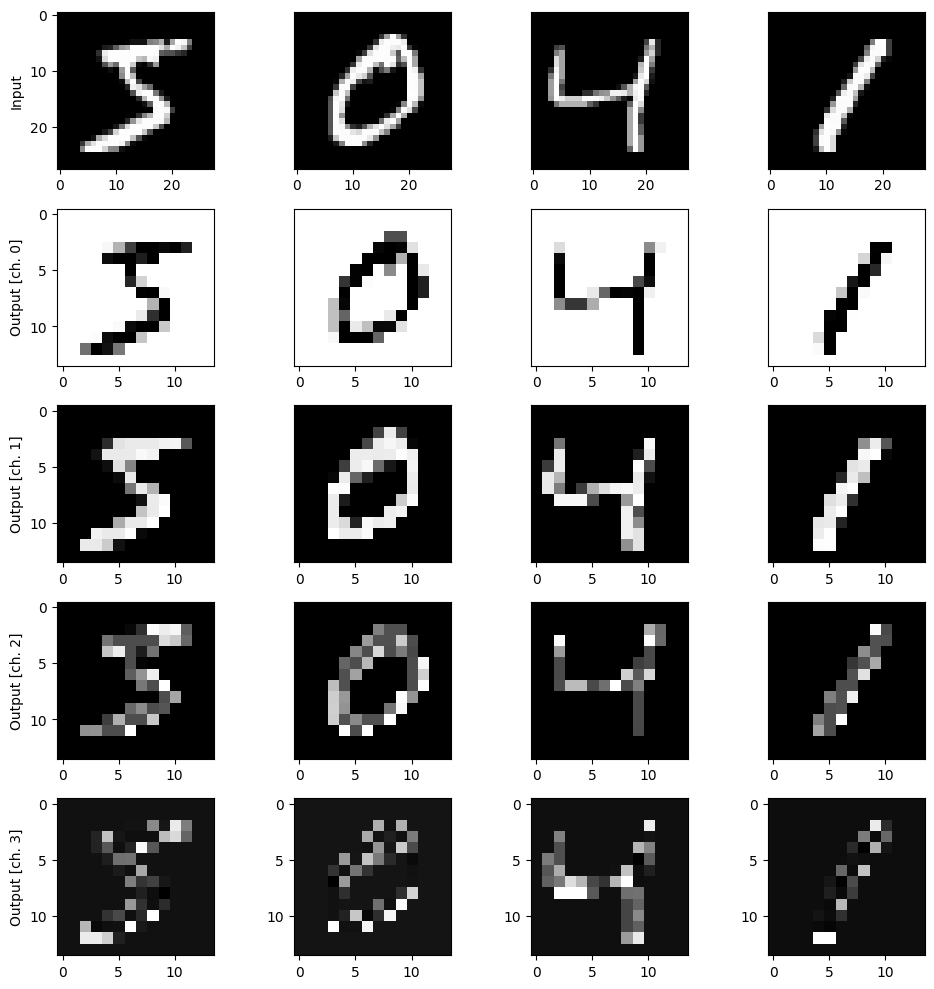

'\nBecause of the quantum kernel, the amount of distortion between subsequent output channels is obvious but the "shape"\nof the numbers are preserved.\n'

In [ ]:
n_samples = 4 # number of samples
n_channels = 4 # number of channels

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10,10)) # initializing fig and axes for plotting.
for k in range(n_samples):
    axes[0,0].set_ylabel("Input") # set the top left hand corner images as Input.
    if k != 0:
        axes[0,k].yaxis.set_visible(False) # hide the yaxis when k is not 0
    axes[0,k].imshow(train_images[k, :, :, 0], cmap="gray") # display train_images data.

    #Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c)) # setting y axis label.
        if k != 0: # if k doenst equal 0
            axes[c, k].yaxis.set_visible(False) # hide the yaxis when k is not 0
        axes[c+1, k].imshow(q_train_images[k, :, :, c], cmap="gray") # display q_train_images data.

plt.tight_layout()
plt.show()

"""
Because of the quantum kernel, the amount of distortion between subsequent output channels is obvious but the "shape"
of the numbers are preserved.
"""

<h2>Hybrid Quantum-Classical Model<h2>

In [ ]:
def MyModel():
    """ Initialize and returns a custom Keras model which is ready to be trained. """
    model = keras.models.Sequential([ # a layer with 10 fully connected nodes.
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax") # very interesting. softmax activation function here
        # converts a vector of numbers into a vector of probabilities.
    ])

    model.compile(
        optimizer='adam', # use the AdamOptimizer.
        loss="sparse_categorical_crossentropy", # cross_entropy is the loss function.
        metrics=["accuracy"], # calculate how often predictions equal input.
    )

    return model


<h2>Training<h2>

In [ ]:
q_model = MyModel()

q_history = q_model.fit( # train the model define above with the given data.
    q_train_images, # this model uses the images prepared by quantum kernels.
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 54ms/step - accuracy: 0.2000 - loss: 2.7022 - val_accuracy: 0.2333 - val_loss: 2.4364
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.4000 - loss: 1.9089 - val_accuracy: 0.1333 - val_loss: 2.2554
Epoch 3/30
13/13 - 0s - 3ms/step - accuracy: 0.5800 - loss: 1.6019 - val_accuracy: 0.3333 - val_loss: 2.0450
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.7400 - loss: 1.3032 - val_accuracy: 0.5333 - val_loss: 1.8848
Epoch 5/30
13/13 - 0s - 3ms/step - accuracy: 0.8800 - loss: 1.0689 - val_accuracy: 0.5333 - val_loss: 1.7706
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.9000 - loss: 0.8867 - val_accuracy: 0.5333 - val_loss: 1.6708
Epoch 7/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.7391 - val_accuracy: 0.5333 - val_loss: 1.5892
Epoch 8/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.6250 - val_accuracy: 0.5333 - val_loss: 1.5236
Epoch 9/30
13/13 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.5331 - val_accuracy: 0.5667 - val_loss: 1.4697
Epoch 10/30
13/13 

In [ ]:
c_model = MyModel()

c_history = c_model.fit( # train the model based on raw MNIST data.
    train_images, # this is just a classical model.
    train_labels,
    validation_data = (test_images, test_labels),
    batch_size = 4,
    epochs = n_epochs,
    verbose = 2,
)

## this will give us the oppurtunity to see the difference in performance between quantum and classical instances.

Epoch 1/30
13/13 - 1s - 41ms/step - accuracy: 0.2400 - loss: 2.3076 - val_accuracy: 0.4667 - val_loss: 2.0230
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.5200 - loss: 1.9194 - val_accuracy: 0.4333 - val_loss: 1.8961
Epoch 3/30
13/13 - 0s - 3ms/step - accuracy: 0.6200 - loss: 1.6455 - val_accuracy: 0.5333 - val_loss: 1.7745
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.7400 - loss: 1.4169 - val_accuracy: 0.5667 - val_loss: 1.6614
Epoch 5/30
13/13 - 0s - 3ms/step - accuracy: 0.8400 - loss: 1.2248 - val_accuracy: 0.6000 - val_loss: 1.5626
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.8400 - loss: 1.0642 - val_accuracy: 0.7000 - val_loss: 1.4795
Epoch 7/30
13/13 - 0s - 3ms/step - accuracy: 0.9200 - loss: 0.9301 - val_accuracy: 0.7000 - val_loss: 1.4104
Epoch 8/30
13/13 - 0s - 3ms/step - accuracy: 0.9200 - loss: 0.8178 - val_accuracy: 0.7000 - val_loss: 1.3527
Epoch 9/30
13/13 - 0s - 3ms/step - accuracy: 0.9200 - loss: 0.7234 - val_accuracy: 0.7000 - val_loss: 1.3042
Epoch 10/30
13/13 

<h2>Results<h2>

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

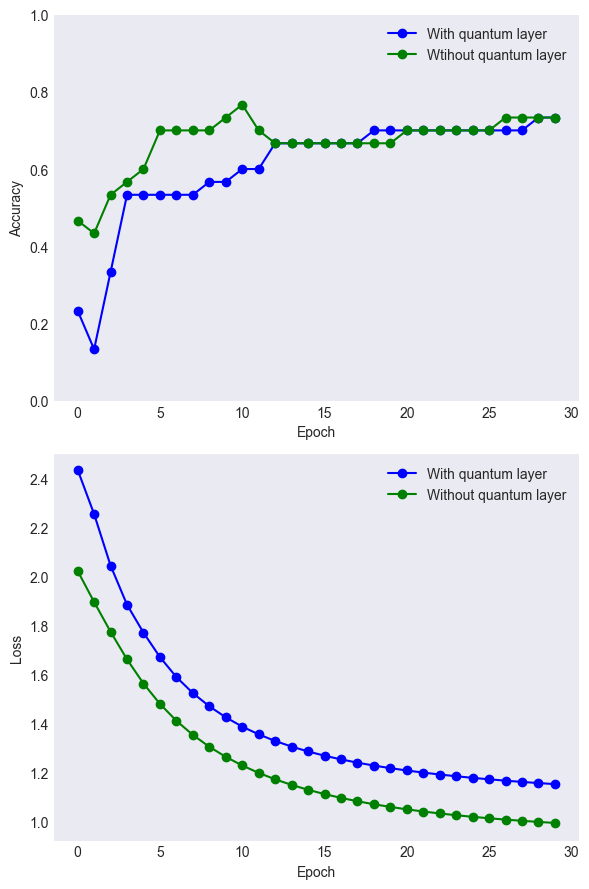

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-dark")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,9))

ax1.plot(q_history.history["val_accuracy"],"-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"],"-og", label="Wtihout quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0,1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Summary<h2>

In this notebook, I followed the "Quanvolutional Neural Networks" tutorial on Pennylane in an attempt to understand the code and reasoning behind the use of quanvolution kernels in image processing.

I initially embedded a 2x2 square into a quantum circuit by applying parameterized rotation gates to qubits in ground state. In order to perform quantum computation, I generated a unitary U with the use of a random circuit and then applied it to the system. Afterwards, I measured the quantum system to obtain a list of expectation values which can be mapped to different channels of a single output pixel. One can recieve a full image after iterating through the process.

According to the plots above, the accuracy contributed by the use of the quantum layer is realized around epoch 5 or the 5th iteration and performs better than classical layers afterwards. In terms of loss, the quantum layer outperforms the classical layer up to epoch 20, but afterwards performance differeences become unnoticeable.




<h2>Just trying some stuff out<h2>

In [ ]:
new_epochs = 100

"""
I want to see what the difference would be with a different epoch number. I suspect that the accuracy would be higher
for large epochs and losses would be lower.
"""

'\nI want to see what the difference would be with a different epoch number. I suspect that the accuracy would be higher\nfor large epochs and losses would be lower.\n'

In [ ]:
c_model = MyModel()

c_history = c_model.fit( # train the model based on raw MNIST data.
    new_train_images,
    new_train_label,
    validation_data = (test_images, test_labels),
    batch_size = 4,
    epochs = new_epochs,
    verbose = 2,
)

Epoch 1/100
13/13 - 1s - 46ms/step - accuracy: 0.2000 - loss: 2.3190 - val_accuracy: 0.4333 - val_loss: 2.0260
Epoch 2/100
13/13 - 0s - 4ms/step - accuracy: 0.5000 - loss: 1.9002 - val_accuracy: 0.5667 - val_loss: 1.9124
Epoch 3/100
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.6139 - val_accuracy: 0.6000 - val_loss: 1.8053
Epoch 4/100
13/13 - 0s - 4ms/step - accuracy: 0.8200 - loss: 1.3830 - val_accuracy: 0.6000 - val_loss: 1.6986
Epoch 5/100
13/13 - 0s - 4ms/step - accuracy: 0.9000 - loss: 1.1917 - val_accuracy: 0.6333 - val_loss: 1.5992
Epoch 6/100
13/13 - 0s - 4ms/step - accuracy: 0.9000 - loss: 1.0330 - val_accuracy: 0.6333 - val_loss: 1.5129
Epoch 7/100
13/13 - 0s - 4ms/step - accuracy: 0.9000 - loss: 0.9015 - val_accuracy: 0.6667 - val_loss: 1.4406
Epoch 8/100
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7920 - val_accuracy: 0.7000 - val_loss: 1.3804
Epoch 9/100
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.7002 - val_accuracy: 0.8000 - val_loss: 1.3299
Epoch 10/

In [ ]:
q_model = MyModel()

q_history = q_model.fit( # train the model define above with the given data.
    q_train_images,
    new_train_label,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=new_epochs,
    verbose=2,
)

Epoch 1/100
13/13 - 1s - 40ms/step - accuracy: 0.1000 - loss: 2.7323 - val_accuracy: 0.0000e+00 - val_loss: 2.2701
Epoch 2/100
13/13 - 0s - 4ms/step - accuracy: 0.3600 - loss: 1.8838 - val_accuracy: 0.2333 - val_loss: 2.0762
Epoch 3/100
13/13 - 0s - 4ms/step - accuracy: 0.6000 - loss: 1.5856 - val_accuracy: 0.4333 - val_loss: 1.9432
Epoch 4/100
13/13 - 0s - 4ms/step - accuracy: 0.8000 - loss: 1.2851 - val_accuracy: 0.5000 - val_loss: 1.7662
Epoch 5/100
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 1.0523 - val_accuracy: 0.5667 - val_loss: 1.6376
Epoch 6/100
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.8719 - val_accuracy: 0.6333 - val_loss: 1.5577
Epoch 7/100
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7317 - val_accuracy: 0.6333 - val_loss: 1.4822
Epoch 8/100
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.6195 - val_accuracy: 0.6333 - val_loss: 1.4149
Epoch 9/100
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.5290 - val_accuracy: 0.6667 - val_loss: 1.3629
Epoch

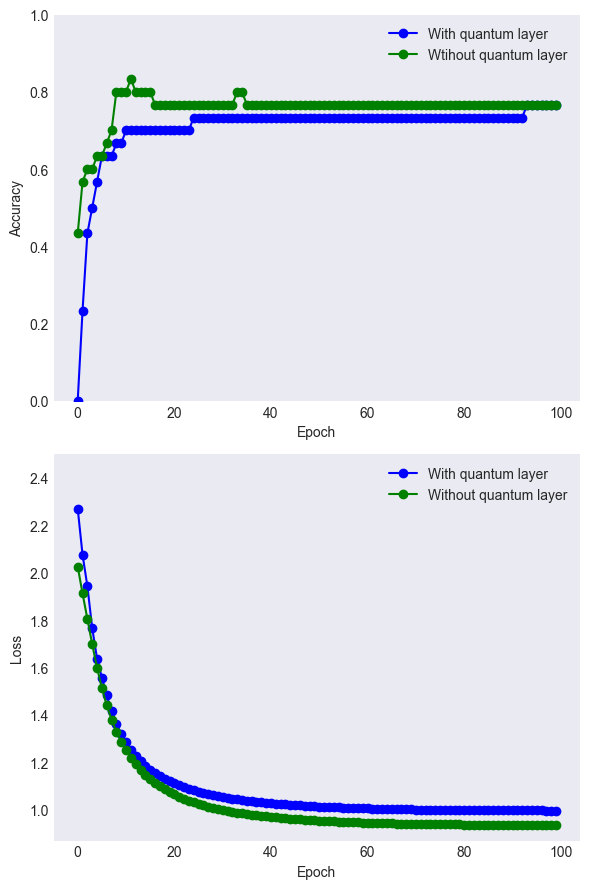

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-dark")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,9))

ax1.plot(q_history.history["val_accuracy"],"-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"],"-og", label="Wtihout quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0,1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

<h2>Summary<h2>

With a larger number of epoch, the values for accuracy and loss settles to some base number. The accuracy for both classical and quantum layers tapers off at around 0.78. The loss equally tapers off for both quantum and classical models with the classical model performing better and attaining least loss.